In [1]:
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import KFold
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot

plt.rcParams['figure.figsize'] = [20, 4]

# reference:
# https://github.com/divensambhwani/MovieLens-100K_Recommender-System/blob/master/MovieLens-100K-Recommeder%20System-SVD.ipynb

In [20]:
data = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
data.head()
print(max(data['item_id']))

1682


In [19]:
user_data = pd.read_csv('ml-100k/u.user', sep='|', names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])
user_data.head()
print(max(user_data['user_id']))

943


TypeError: 'DatasetAutoFolds' object is not subscriptable

(array([ 6110., 11370., 27145., 34174., 21201.]),
 array([1., 2., 3., 4., 5., 6.]),
 <BarContainer object of 5 artists>)

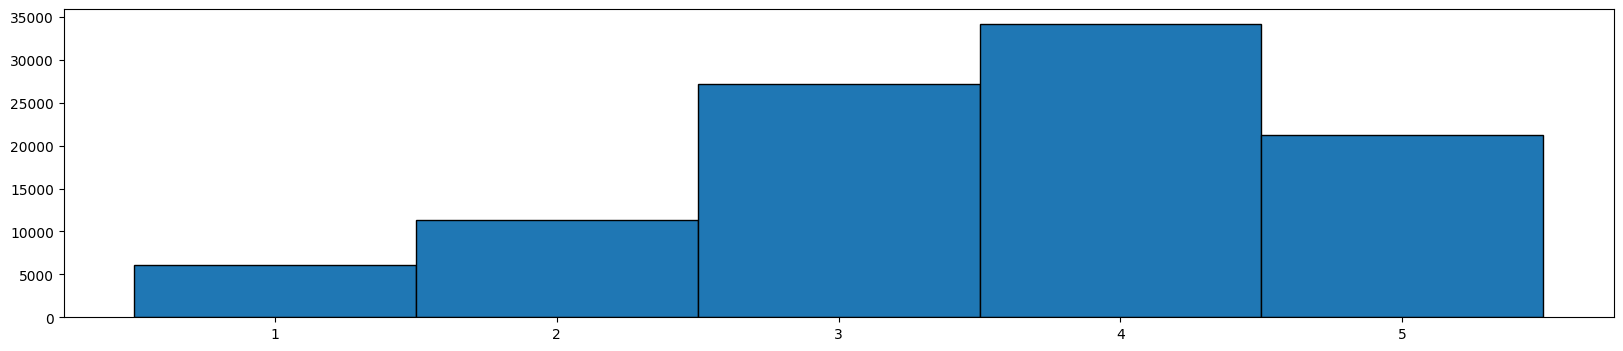

In [4]:
# distribution of ratings
plt.hist(data['rating'], bins=[1, 2, 3, 4, 5, 6], edgecolor='black', align='left')

<StemContainer object of 3 artists>

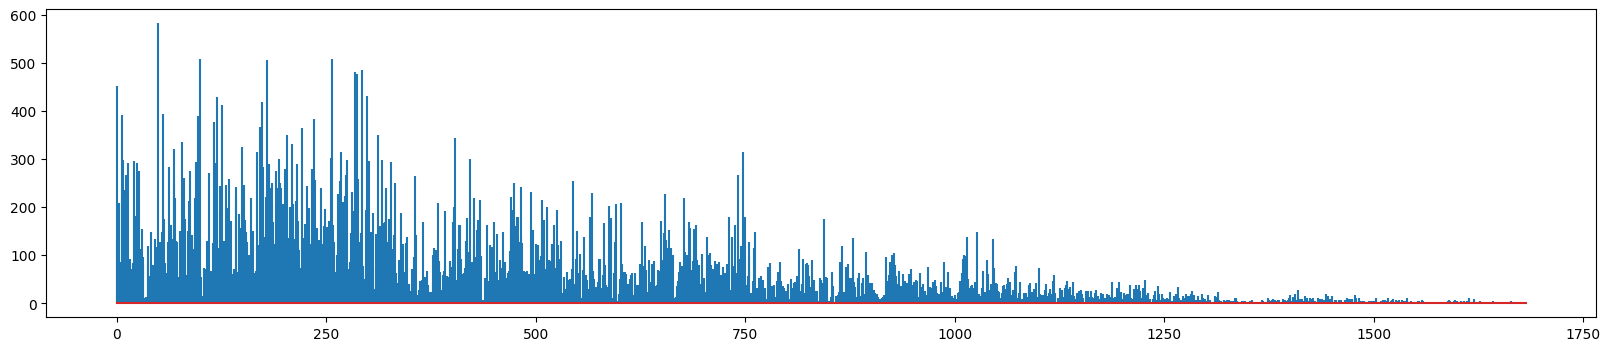

In [5]:
# distribution of ratings for each movie
grp_data = data.groupby('item_id')['rating'].count()

plt.stem(grp_data, markerfmt='')

In [6]:
reader = Reader(line_format='user item rating timestamp', sep='\t')

reader = Reader(rating_scale=(0.5, 5.0))

data = Dataset.load_from_df(data[['user_id', 'item_id', 'rating']], reader)

benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), NMF(), NormalPredictor(), KNNBasic()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]],index=['Algorithm']))
    benchmark.append(tmp)

/tmp/ipykernel_54152/4102214296.py:15: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_54152/4102214296.py:15: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_54152/4102214296.py:15: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


/tmp/ipykernel_54152/4102214296.py:15: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [7]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
SVD,0.946410,0.704255,0.149987
NMF,0.972963,1.045845,0.113164
KNNBasic,0.989070,0.113077,2.211658
NormalPredictor,1.526185,0.057175,0.113202


In [8]:
param_grid = {'n_factors': [25, 30, 35, 40], 'n_epochs': [15, 20, 25], 'lr_all': [0.001, 0.003, 0.005, 0.008], 'reg_all': [0.08, 0.1, 0.15]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)
algo = gs.best_estimator['rmse']
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

t = gs.best_params

factors = t['rmse']['n_factors']
epochs = t['rmse']['n_epochs']
lr_value = t['rmse']['lr_all']
reg_value = t['rmse']['reg_all']

trainset, testset = train_test_split(data, test_size=0.25)
algo = SVD(n_factors=factors, n_epochs=epochs, lr_all=lr_value, reg_all=reg_value)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

# exec time 4 min 16 sec

0.9278524345756831
{'n_factors': 35, 'n_epochs': 25, 'lr_all': 0.008, 'reg_all': 0.08}
RMSE: 0.9155


0.9154638478619022

In [10]:


def get_user_ratings(uid):
    """ 
    args: 
      uid: user id
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_item_ratings(iid):
    """ 
    args:
      iid: the item id
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0

    
df_predictions = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_predictions['Iu'] = df_predictions.uid.apply(get_user_ratings)
df_predictions['Ui'] = df_predictions.iid.apply(get_item_ratings)
df_predictions['err'] = abs(df_predictions.est - df_predictions.rui)
df_predictions.head()


,uid,iid,rui,est,details,Iu,Ui,err
0,216,764,2.0,3.173143,{'was_impossible': False},93,24,1.173143
1,660,1178,1.0,1.928737,{'was_impossible': False},163,13,0.928737
2,650,202,3.0,3.336784,{'was_impossible': False},237,204,0.336784
3,394,655,5.0,4.267741,{'was_impossible': False},115,174,0.732259
4,836,324,4.0,3.149860,{'was_impossible': False},39,93,0.850140


In [12]:
best_predictions = df_predictions.sort_values(by='err')[:10]
worst_predictions = df_predictions.sort_values(by='err')[-10:]

In [13]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
19477,688,304,5.0,5.0,{'was_impossible': False},18,107,0.0
19788,907,520,5.0,5.0,{'was_impossible': False},121,93,0.0
13187,507,222,5.0,5.0,{'was_impossible': False},45,271,0.0
21451,270,50,5.0,5.0,{'was_impossible': False},107,417,0.0
5592,849,197,5.0,5.0,{'was_impossible': False},17,188,0.0
19886,367,302,5.0,5.0,{'was_impossible': False},42,236,0.0
7702,118,23,5.0,5.0,{'was_impossible': False},51,129,0.0
20927,24,64,5.0,5.0,{'was_impossible': False},53,204,0.0
23431,332,64,5.0,5.0,{'was_impossible': False},137,204,0.0
14704,137,50,5.0,5.0,{'was_impossible': False},33,417,0.0


In [14]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
12215,343,234,1.0,4.387397,{'was_impossible': False},184,214,3.387397
9339,887,699,1.0,4.389397,{'was_impossible': False},129,86,3.389397
10835,405,47,5.0,1.567454,{'was_impossible': False},559,93,3.432546
11456,270,237,1.0,4.435898,{'was_impossible': False},107,286,3.435898
19998,127,268,1.0,4.437268,{'was_impossible': False},14,194,3.437268
13884,434,9,1.0,4.466259,{'was_impossible': False},29,218,3.466259
24797,405,376,5.0,1.485730,{'was_impossible': False},559,17,3.514270
3772,239,190,1.0,4.552261,{'was_impossible': False},115,91,3.552261
5924,239,64,1.0,4.609879,{'was_impossible': False},115,204,3.609879
11400,481,318,1.0,4.675818,{'was_impossible': False},44,230,3.675818
